In [4]:
from sympy import symbols, cos, sin, diff, Function, simplify

# Define symbols
theta = symbols('theta')
k, e, h, GM, sigma = symbols('k e h GM sigma')

# Define r(theta)
r = (h ** 2 / GM) / (1 + k * e * sin(theta / sigma))

# Calculate dr/dtheta
dr_dtheta = diff(r, theta)

# Define omega(theta) = dtheta/dt
omega = h / r**2

# Calculate d^2r/dtheta^2
d2r_dtheta2 = diff(dr_dtheta, theta)

# Calculate domega/dtheta
domega_dtheta = diff(omega, theta)

dr_dt = diff(r,theta)*omega
# Calculate d^2r/dt^2 using chain rule
d2r_dt2 = simplify(d2r_dtheta2 * omega**2 + dr_dtheta * domega_dtheta * omega)

# Calculate d^2theta/dt^2
# Differentiate omega(theta)
d2theta_dt2 = simplify(domega_dtheta * omega)

# Display the results
print(f"dr/dt= {dr_dt}")
print(f"dr/dtheta = {dr_dtheta}")
print(f"d^2r/dtheta^2 = {d2r_dtheta2}")
print(f"domega/dtheta = {domega_dtheta}")
print(f"d^2r/dt^2 = {d2r_dt2}")
print(f"d^2theta/dt^2 = {d2theta_dt2}")


dr/dt= -GM*e*k*cos(theta/sigma)/(h*sigma)
dr/dtheta = -e*h**2*k*cos(theta/sigma)/(GM*sigma*(e*k*sin(theta/sigma) + 1)**2)
d^2r/dtheta^2 = 2*e**2*h**2*k**2*cos(theta/sigma)**2/(GM*sigma**2*(e*k*sin(theta/sigma) + 1)**3) + e*h**2*k*sin(theta/sigma)/(GM*sigma**2*(e*k*sin(theta/sigma) + 1)**2)
domega/dtheta = 2*GM**2*e*k*(e*k*sin(theta/sigma) + 1)*cos(theta/sigma)/(h**3*sigma)
d^2r/dt^2 = GM**3*e*k*(e*k*sin(theta/sigma) + 1)**2*sin(theta/sigma)/(h**4*sigma**2)
d^2theta/dt^2 = 2*GM**4*e*k*(e*k*sin(theta/sigma) + 1)**3*cos(theta/sigma)/(h**6*sigma)


In [14]:
import numpy as np
from scipy.optimize import minimize
from scipy.integrate import quad
import matplotlib.pyplot as plt
from astropy import constants as cc, units as uu

# Constants
c = cc.c.si.value
G = cc.G  # gravitational constant in m^3 kg^-1 s^-2
M = cc.M_sun  # mass of the Sun in kg
c = cc.c.si.value  # speed of light in m/s
GM = (G*M).si.value  # gravitational parameter for the Sun in m^3/s^2
# Define the impact parameter and initial velocity
b = 7.0e8  # impact parameter in meters
v_0 = 5.0e4  # initial velocity in m/s (placeholder value)
h = b * v_0

def r_derivatives(theta, h, e, GM, x):
    sigma = x[0]
    k = x[1]
    r0=GM/c**2*(k**2*e**2-1)
    # Expression for r, r_dot, and r_double_dot
    r = -r0 / (1 + k * e * np.cos(theta / sigma))
    theta_dot = h / r ** 2
    dr_dt= GM*e*np.sin(theta/sigma)/(h*sigma)
    dr_dtheta = e*h**2*np.sin(theta/sigma)/(GM*sigma*(e*np.cos(theta/sigma) + 1)**2)
    d2r_dtheta_2 = 2*e**2*h**2**2*np.sin(theta/sigma)**2/(GM*sigma**2*(e*np.cos(theta/sigma) + 1)**3) + e*h**2*np.cos(theta/sigma)/(GM*sigma**2*(e*np.cos(theta/sigma) + 1)**2)
    domega_dtheta = -2*GM**2*e*(e*np.cos(theta/sigma) + 1)*np.sin(theta/sigma)/(h**3*sigma)
    d2r_dt2 = GM**3*e*(e*np.cos(theta/sigma) + 1)**2*np.cos(theta/sigma)/(h**4*sigma**2)
    d2theta_dt2 = -2*GM**4*e*(e*np.cos(theta/sigma) + 1)**3*np.sin(theta/sigma)/(h**6*sigma)
    return r, dr_dt, d2r_dt2, theta_dot

def new_grav_accel(theta, h, GM, x):
    r, r_dot, r_double_dot, theta_dot = r_derivatives(theta, h,e, GM, x)
    v_squared = r_dot**2 + r**2 * theta_dot**2
    v = np.sqrt(v_squared)
    gamma_v = 1 / np.sqrt(1 - v**2 / c**2)
    a_theoretical = -GM / gamma_v / r**2 / (1 + (gamma_v - 1) * (r_dot / v)**2)
    return a_theoretical, r, r_double_dot, theta_dot

def error_function(x):
    def integrand(theta):
        a_theoretical, r, r_double_dot, theta_dot = new_grav_accel(theta, h, GM, x)
        # No need to calculate a_theoretical here again, it is returned from the new_grav_accel function
        a_numerical = r_double_dot - r * theta_dot ** 2  # Assuming r_double_dot is defined to calculate \ddot{r}
        return (a_theoretical - a_numerical)**2
    integral_error, _ = quad(integrand, 0, 2 * np.pi, epsabs=1e-6, epsrel=1e-6)
    return 100 * integral_error


# Initial guess for sigma
initial_x = [0.9, h]
result = minimize(error_function, initial_x, method='Nelder-Mead', tol=1E-6)
print("Optimized sigma:", result.x)




# Assuming k_optimized is the optimized value of k (eccentricity) obtained from the previous step
e_optimized = result.x[1]  # For example

# Calculate the deflection angle Δθ in radians
delta_theta = 2 * np.arctan(np.sqrt(e_optimized**2-1) / e_optimized)

# Convert the deflection angle from radians to degrees, if necessary
delta_theta_degrees = np.degrees(delta_theta)

print(f"The deflection angle Δθ is {delta_theta:.6f} radians or {delta_theta_degrees:.6f} degrees.")

TypeError: loop of ufunc does not support argument 0 of type Add which has no callable sqrt method

In [6]:
import numpy as np
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11  # gravitational constant
M = 1.989e+30    # mass of the Sun, in kilograms

# New gravitational force law (example: same as Newton's, but with a small modification)
def new_grav_force(r):
    return G * M / r**2  # This should be replaced with the new law

# Equations of motion
def equations(t, y):
    r, theta, dr, dtheta = y
    fr = -new_grav_force(r) / M  # force per unit mass (acceleration)
    r_dot_dot = fr + r * dtheta**2
    theta_dot_dot = -2 * dr * dtheta / r
    return [dr, dtheta, r_dot_dot, theta_dot_dot]

# Initial conditions
r0 = 7.0e8  # initial distance from Sun's center in meters (just above the surface)
theta0 = 0  # starting at angle 0
dr0 = 0     # initial radial velocity (assume starting from rest)
dtheta0 = np.sqrt(G * M / r0**3)  # initial angular velocity for a near-circular orbit

# Time span
t_span = (0, 31536000)  # one year in seconds
t_eval = np.linspace(0, 31536000, 1000)  # evaluate at these times

# Solve the ODE
sol = solve_ivp(equations, t_span, [r0, theta0, dr0, dtheta0], t_eval=t_eval, method='RK45')

# Results
r_vals = sol.y[0]
theta_vals = sol.y[1]

# Calculate angular deviation
angular_deviation = theta_vals[-1] - theta_vals[0]

print(f"Angular Deviation: {angular_deviation} radians")


Angular Deviation: 1.5723532397823035 radians


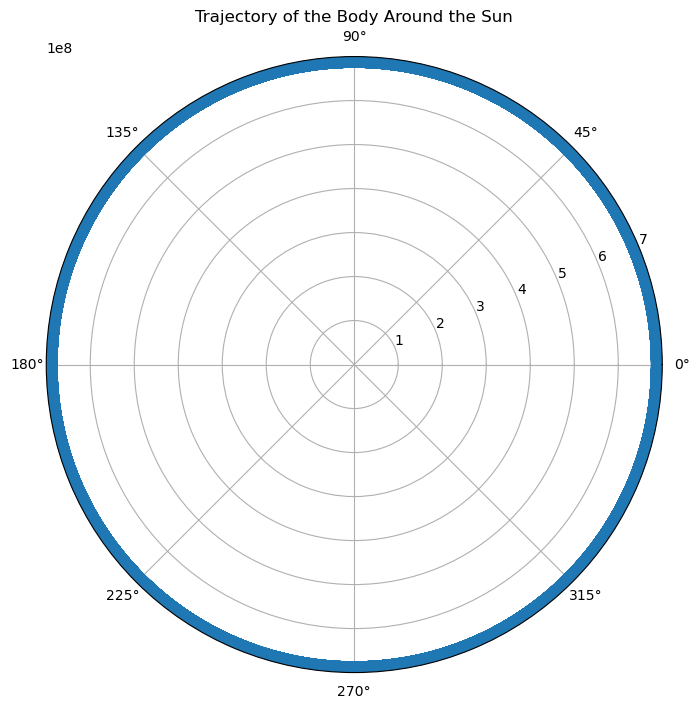

Angular Deviation: 39238.265005 radians


In [7]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Constants
G = 6.67430e-11  # gravitational constant, m^3 kg^-1 s^-2
M = 1.989e+30    # mass of the Sun, kg
epsilon = 0.1    # small constant in the new gravitational law

# New gravitational force law
def new_grav_force(r, beta):
    return (G * M / r**2) * (1 + epsilon * np.cos(beta))

# Equations of motion
def equations(t, y):
    r, theta, dr, dtheta = y
    vr = dr
    vt = r * dtheta
    beta = np.arccos(vr / np.sqrt(vr**2 + vt**2))
    fr = -new_grav_force(r, beta)  # force per unit mass (acceleration)
    r_dot_dot = fr + r * dtheta**2
    theta_dot_dot = -2 * dr * dtheta / r
    return [dr, dtheta, r_dot_dot, theta_dot_dot]

# Initial conditions
r0 = 7.0e8  # initial radial distance from Sun's center (above surface)
theta0 = 0  # initial angular position
dr0 = 0     # initial radial velocity
dtheta0 = np.sqrt(G * M / r0**3)  # initial angular velocity for near-circular orbit

# Time span for the simulation
t_span = (0, 2 * 31536000)  # simulate for 2 years
t_eval = np.linspace(*t_span, 3000)  # time points to evaluate

# Solve the ODE
sol = solve_ivp(equations, t_span, [r0, theta0, dr0, dtheta0], t_eval=t_eval, method='RK45')

# Plotting the results
r_vals = sol.y[0]
theta_vals = sol.y[1]

plt.figure(figsize=(8, 8))
plt.polar(theta_vals, r_vals)
plt.title("Trajectory of the Body Around the Sun")
plt.show()

# Calculate angular deviation
angular_deviation = theta_vals[-1] - theta_vals[0]
print(f"Angular Deviation: {angular_deviation:.6f} radians")
